# Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from datetime import datetime
from datetime import date
from datetime import timedelta
import yfinance as yf
import datetime
from workalendar.america import Brazil
import plotly.graph_objects as go

# Gerando os DataFrames

In [2]:
start_date = '1994-03-01'
final_date = '2022-10-04'

## IBOV

In [3]:
df_ibov = pd.DataFrame()
df_ibov['IBOV'] = yf.download('^BVSP', start = start_date, end = final_date, interval = '1d')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
df_ibov.head()

,IBOV
Date,
1994-03-01,1073.300049
1994-03-02,1021.500000
1994-03-03,1045.800049
1994-03-04,1114.000000
1994-03-07,1193.900024


## IPCA

In [5]:
url_bcb = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json'
ipca = pd.read_json(url_bcb)
ipca['data'] = pd.to_datetime(ipca['data'], dayfirst = True)
ipca.rename(columns={'data': 'Date'}, inplace = True)
ipca.rename(columns={'valor': 'value'}, inplace = True)
ipca.set_index('Date', inplace = True)
ipca = ipca.loc[start_date:]

In [6]:
ipca = ipca / 100
ipca.head()

,value
Date,
1994-03-01,0.4275
1994-04-01,0.4268
1994-05-01,0.4403
1994-06-01,0.4743
1994-07-01,0.0684


In [7]:
df_ipca = pd.DataFrame()
df_ipca.index = pd.date_range(start_date, final_date, freq = 'D')
df_ipca.head()

""
1994-03-01
1994-03-02
1994-03-03
1994-03-04
1994-03-05


In [8]:
list_aux = []
for i in df_ipca.index:
    if len(str(i.month)) == 1:
        list_aux.append(f'{i.year}-0{i.month}')
    else:
        list_aux.append(f'{i.year}-{i.month}')

In [9]:
df_ipca['date_aux'] = list_aux
df_ipca.head()

,date_aux
1994-03-01,1994-03
1994-03-02,1994-03
1994-03-03,1994-03
1994-03-04,1994-03
1994-03-05,1994-03


In [10]:
list_ipca = []
for i in df_ipca['date_aux']:
    for index, row in ipca.iterrows():
        if i == index.strftime('%Y-%m'):
            list_ipca.append(row['value'])

In [11]:
df_ipca['IPCA'] = list_ipca

## IPCA dias úteis (pregão)

In [12]:
cal = Brazil()

ipca_util = {}

for data, valor in df_ipca.itertuples(index = False):
    
    month_int = int(data.split('-')[1])
    month_str = data.split('-')[1]
    year = int(data.split('-')[0])
    
    if month_int == 1 or month_int == 3 or month_int == 5 or month_int == 7 or month_int == 8 or month_int == 10 or month_int == 12:
        
        working_day = cal.get_working_days_delta(date(year, month_int, 1), date(year, month_int, 31))
        ipca_util[f'{year}-{month_str}'] = ((1 + valor)**(1/working_day)) - 1
        
    elif month_int == 2:
        
        working_day = cal.get_working_days_delta(date(year, month_int, 1), date(year, month_int, 28))
        ipca_util[f'{year}-{month_str}'] = ((1 + valor)**(1/working_day)) - 1
        
    elif month_int == 4 or month_int == 6 or month_int == 9 or month_int == 11:
        
        working_day = cal.get_working_days_delta(date(year, month_int, 1), date(year, month_int, 30))
        ipca_util[f'{year}-{month_str}'] = ((1 + valor)**(1/working_day)) - 1

In [13]:
df_ipca_util = pd.DataFrame(data = ipca_util.values(), index = ipca_util.keys(), columns = ['IPCA_dia_util'])

In [14]:
df_ipca_util

,IPCA_dia_util
1994-03,0.016310
1994-04,0.018883
1994-05,0.016722
1994-06,0.018657
1994-07,0.003314
...,...
2022-06,0.000318
2022-07,-0.000341
2022-08,-0.000164
2022-09,-0.000145


In [15]:
df_ipca_corrigido = pd.merge(df_ipca, df_ipca_util, how = 'outer', left_on = 'date_aux', right_on = df_ipca_util.index)

In [16]:
df_ipca_corrigido.index = df_ipca.index

In [17]:
df_ipca_corrigido.head()

,date_aux,IPCA,IPCA_dia_util
1994-03-01,1994-03,0.4275,0.01631
1994-03-02,1994-03,0.4275,0.01631
1994-03-03,1994-03,0.4275,0.01631
1994-03-04,1994-03,0.4275,0.01631
1994-03-05,1994-03,0.4275,0.01631


## Dataframe final

In [18]:
df_final = pd.merge(df_ibov, df_ipca_corrigido, how = 'inner', left_index = True, right_index = True)
df_final['IPCA_dia_util'] = df_final['IPCA_dia_util'] + 1
df_final['IPCA_cumulative'] = df_final['IPCA_dia_util'].cumprod()
df_final.head()

,IBOV,date_aux,IPCA,IPCA_dia_util,IPCA_cumulative
1994-03-01,1073.300049,1994-03,0.4275,1.01631,1.016310
1994-03-02,1021.500000,1994-03,0.4275,1.01631,1.032886
1994-03-03,1045.800049,1994-03,0.4275,1.01631,1.049732
1994-03-04,1114.000000,1994-03,0.4275,1.01631,1.066853
1994-03-07,1193.900024,1994-03,0.4275,1.01631,1.084254


# IBOV retorno real anual

In [19]:
ibov_retorno_anual_real = df_final.copy()

In [20]:
ibov_retorno_anual_real['IPCA_aux'] = ibov_retorno_anual_real['IPCA_cumulative'].shift(252 + 1)
ibov_retorno_anual_real.replace(to_replace = ibov_retorno_anual_real['IPCA_aux'].iloc[252], value = 1, inplace = True)
ibov_retorno_anual_real['IPCA_adjusted'] = ibov_retorno_anual_real['IPCA_cumulative'] / ibov_retorno_anual_real['IPCA_aux']
ibov_retorno_anual_real['IBOV'] = ibov_retorno_anual_real['IBOV'].diff(periods = 252) / ibov_retorno_anual_real['IBOV'].shift(252)
ibov_retorno_anual_real['real_return'] = ((ibov_retorno_anual_real['IBOV'] + 1) / ibov_retorno_anual_real['IPCA_adjusted']) - 1
ibov_retorno_anual_real.drop(columns = {'IBOV', 'date_aux', 'IPCA', 'IPCA_aux', 'IPCA_cumulative', 'IPCA_adjusted', 'IPCA_dia_util'}, 
               inplace = True)
ibov_retorno_anual_real = ibov_retorno_anual_real.iloc[252:]

In [21]:
ibov_retorno_anual_real

,real_return
1995-03-09,-0.623595
1995-03-10,-0.495419
1995-03-13,-0.502306
1995-03-14,-0.464016
1995-03-15,-0.505132
...,...
2022-09-27,-0.117020
2022-09-28,-0.109674
2022-09-29,-0.117833
2022-09-30,-0.069398


# Retorno real por governo

In [22]:
governos = [{'Fernando_Henrique': {'dt_inicio': '1995-01-01', 'dt_fim': '2003-01-01'}}, 
            {'Lula': {'dt_inicio': '2003-01-01', 'dt_fim': '2011-01-01'}},
            {'Dilma_Roussef': {'dt_inicio': '2011-01-01', 'dt_fim': '2016-08-31'}},
            {'Michel_Temer': {'dt_inicio': '2016-08-31', 'dt_fim': '2019-01-01'}},
            {'Jair_Bolsonaro': {'dt_inicio': '2019-01-01', 'dt_fim': '2022-10-03'}}]

In [23]:
retornos_gov = {}
periodo_gov = {}

for governo in governos:
    
    df_governo = df_final.copy()
    nome_governo = list(iter(governo))[0]
    df_governo = df_governo.loc[governo.get(nome_governo).get('dt_inicio'): governo.get(nome_governo).get('dt_fim')]
    ipca_acumulado = df_governo['IPCA_cumulative'].iloc[-1] / df_governo['IPCA_cumulative'].iloc[0]
    ibov_acumulado = (df_governo['IBOV'].iloc[-1] - df_governo['IBOV'].iloc[0]) / df_governo['IBOV'].iloc[0]
    retornos_gov[nome_governo] = ((ibov_acumulado + 1) / ipca_acumulado) - 1
    periodo_gov[nome_governo] = (df_governo.index[-1] - df_governo.index[0]).days

In [24]:
print(retornos_gov)

{'Fernando_Henrique': 0.3116872478030446, 'Lula': 2.8252157495439834, 'Dilma_Roussef': -0.43862758900315024, 'Michel_Temer': 0.40925451647228517, 'Jair_Bolsonaro': 0.02268660079817919}


In [25]:
print(periodo_gov)

{'Fernando_Henrique': 2919, 'Lula': 2919, 'Dilma_Roussef': 2067, 'Michel_Temer': 849, 'Jair_Bolsonaro': 1370}


In [26]:
retorno_anualizado = {}

for key, value in retornos_gov.items():
    
    retorno_anualizado[key] = ((1 + value)**(360/periodo_gov[key])) - 1

In [27]:
print(retorno_anualizado )

{'Fernando_Henrique': 0.03402728705347857, 'Lula': 0.17993722501132758, 'Dilma_Roussef': -0.09566737864670116, 'Michel_Temer': 0.15658014447139812, 'Jair_Bolsonaro': 0.005912234444276798}


# Visualização gráfica

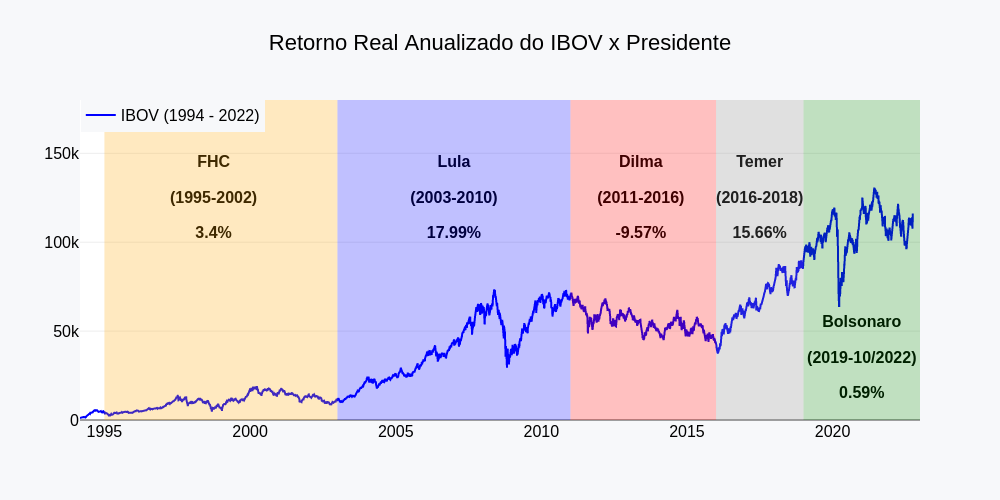

In [28]:
#Gerando objeto Figura
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_final.index, y = df_final['IBOV'], 
                        name = 'IBOV (1994 - 2022)', line = dict(color = 'blue', width = 2)))

#FHC
fig.add_vrect(x0 = '1995', x1 = '2003', fillcolor = 'orange', opacity = 0.25, line_width = 0)
fig.add_trace(go.Scatter(x = ['1998-10-01'], y = [100000], mode = 'text', textposition = 'top center', showlegend = False,
                         text = f"<b>{round(100 * retorno_anualizado['Fernando_Henrique'], 2)}%"))
fig.add_trace(go.Scatter(x = ['1998-10-01'], y = [120000], mode = 'text', text = '<b>(1995-2002)', textposition = 'top center', 
                         showlegend = False))
fig.add_trace(go.Scatter(x = ['1998-10-01'], y = [140000], mode = 'text', text = '<b>FHC', textposition = 'top center', 
                         showlegend = False))

#Lula
fig.add_vrect(x0 = '2003', x1 = '2011', fillcolor = 'blue', opacity = 0.25, line_width = 0)
fig.add_trace(go.Scatter(x = ['2007'], y = [100000], mode = 'text', textposition = 'top center', showlegend = False,
                         text = f"<b>{round(100 * retorno_anualizado['Lula'], 2)}%"))
fig.add_trace(go.Scatter(x = ['2007'], y = [120000], mode = 'text', text = '<b>(2003-2010)', textposition = 'top center', 
                         showlegend = False))
fig.add_trace(go.Scatter(x = ['2007'], y = [140000], mode = 'text', text = '<b>Lula', textposition = 'top center', 
                         showlegend = False))

#Dilma
fig.add_vrect(x0 = '2011', x1 = '2016', fillcolor = 'red', opacity = 0.25, line_width = 0)
fig.add_trace(go.Scatter(x = ['2013-06-01'], y = [100000], mode = 'text', textposition = 'top center', showlegend = False,
                         text = f"<b>{round(100 * retorno_anualizado['Dilma_Roussef'], 2)}%"))
fig.add_trace(go.Scatter(x = ['2013-06-01'], y = [120000], mode = 'text', text = '<b>(2011-2016)', textposition = 'top center', 
                         showlegend = False))
fig.add_trace(go.Scatter(x = ['2013-06-01'], y = [140000], mode = 'text', text = '<b>Dilma', textposition = 'top center', 
                         showlegend = False))

#Temer
fig.add_vrect(x0 = '2016', x1 = '2019', fillcolor = 'gray', opacity = 0.25, line_width = 0)
fig.add_trace(go.Scatter(x = ['2017-07-01'], y = [100000], mode = 'text',  textposition = 'top center', showlegend = False,
                         text = f"<b>{round(100 * retorno_anualizado['Michel_Temer'], 2)}%"))
fig.add_trace(go.Scatter(x = ['2017-07-01'], y = [120000], mode = 'text', text = '<b>(2016-2018)', textposition = 'top center', 
                         showlegend = False))
fig.add_trace(go.Scatter(x = ['2017-07-01'], y = [140000], mode = 'text', text = '<b>Temer', textposition = 'top center', 
                         showlegend = False))

#Bolsonaro
fig.add_vrect(x0 = '2019', x1 = '2023', fillcolor = 'green', opacity = 0.25, line_width = 0)
fig.add_trace(go.Scatter(x = ['2021'], y = [10000], mode = 'text', textposition = 'top center', showlegend = False, 
                         text = f"<b>{round(100 * retorno_anualizado['Jair_Bolsonaro'], 2)}%"))
fig.add_trace(go.Scatter(x = ['2021'], y = [30000], mode = 'text', text = '<b>(2019-10/2022)', textposition = 'top center', 
                         showlegend = False))
fig.add_trace(go.Scatter(x = ['2021'], y = [50000], mode = 'text', text = '<b>Bolsonaro', textposition = 'top center', 
                         showlegend = False))

fig.update_layout(title = 'Retorno Real Anualizado do IBOV x Presidente', xaxis_title = '', yaxis_title = '', legend_title = '',
                 font = dict(family = 'Arial, Arial, Arial, Arial, Arial', size = 16, color = 'black'), 
                  paper_bgcolor = '#f7f8fa')

#Update Layout
fig.update_layout(xaxis_rangeslider_visible = False, width = 1000, height = 500, template = 'xgridoff',
                  legend = dict(orientation = 'h', yanchor = 'bottom', y = 0.9, xanchor = 'right', x = 0.22))

fig.update_layout(yaxis_range=[0,180000])

fig.show('png')